In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  9 03:14:49 2023
@author: liang
"""
%matplotlib widget
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
## Load the data matrix and normalize the point coordinates by translating them to the mean of the 
## points in each view (see lecture for details).
data = []
f = open('./factorization_data/measurement_matrix.txt', 'r')
for line in f:
    data.append(np.array(line.split(' '), dtype=float))
D = np.array(data) - np.mean(data, axis=1)[:, np.newaxis]


In [3]:
## Apply SVD to the 2M x N data matrix to express it as D = U @ W @ V' (using NumPy notation) where 
## U is a 2Mx3 matrix, W is a 3x3 matrix of the top three singular values, and V is a Nx3 matrix. 
## You can use numpy.linalg.svd to compute this decomposition. Next, derive structure and motion 
## matrices from the SVD as explained in the lecture.
U, s, V = np.linalg.svd(D)
U3 = U[:,:3]
s3 = np.identity(3) * s[:3]
V3 = V[:3,:]
Motion = U3 @ np.sqrt(s3)
Structure = np.sqrt(s3) @ V3


In [4]:
## Find the matrix Q to eliminate the affine ambiguity using the method described on slide 32.
F = Motion.shape[0] // 2
i, j = np.zeros((F, Motion.shape[1])), np.zeros((F, Motion.shape[1]))
for idx in range(F):
    idx_i = 2 * idx
    idx_j = 2 * idx + 1
    i[idx,:] = Motion[idx_i,:]
    j[idx,:] = Motion[idx_j,:]

A = np.zeros((2*F, 6))
for f in range(F):
    A[0*F+f, 0] = i[f,0] **2 - j[f,0] **2
    A[0*F+f, 1] = i[f,1] **2 - j[f,1] **2
    A[0*F+f, 2] = i[f,2] **2 - j[f,2] **2
    A[0*F+f, 3] = 2 * i[f,0] * i[f,1] - 2 * j[f,0] * j[f,1]
    A[0*F+f, 4] = 2 * i[f,0] * i[f,2] - 2 * j[f,0] * j[f,2]
    A[0*F+f, 5] = 2 * i[f,1] * i[f,2] - 2 * j[f,1] * j[f,2]
    A[1*F+f, 0] = i[f,0] * j[f,0]
    A[1*F+f, 1] = i[f,1] * j[f,1]
    A[1*F+f, 2] = i[f,2] * j[f,2]
    A[1*F+f, 3] = i[f,0] * j[f,1] + i[f,1] * i[f,0]
    A[1*F+f, 4] = i[f,0] * j[f,2] + i[f,2] * j[f,0]
    A[1*F+f, 5] = i[f,1] * j[f,2] + i[f,2] * j[f,1]

_, _, v = np.linalg.svd(A)
x = v[-1,:]
L = np.array([[x[0], x[3], x[4]], 
              [x[3], x[1], x[5]], 
              [x[4], x[5], x[2]]])

Q = np.linalg.cholesky(L)
Motion_new = Motion @ Q
Structure_new = np.linalg.inv(Q) @ Structure


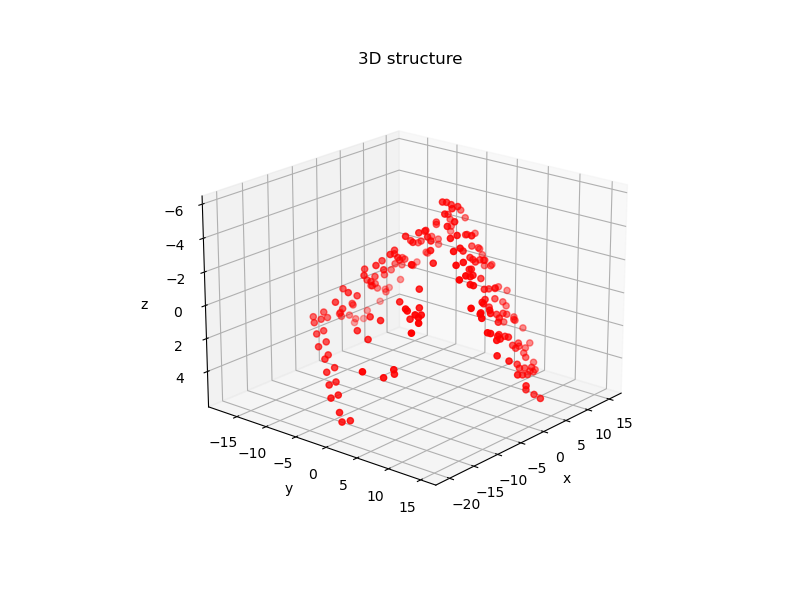

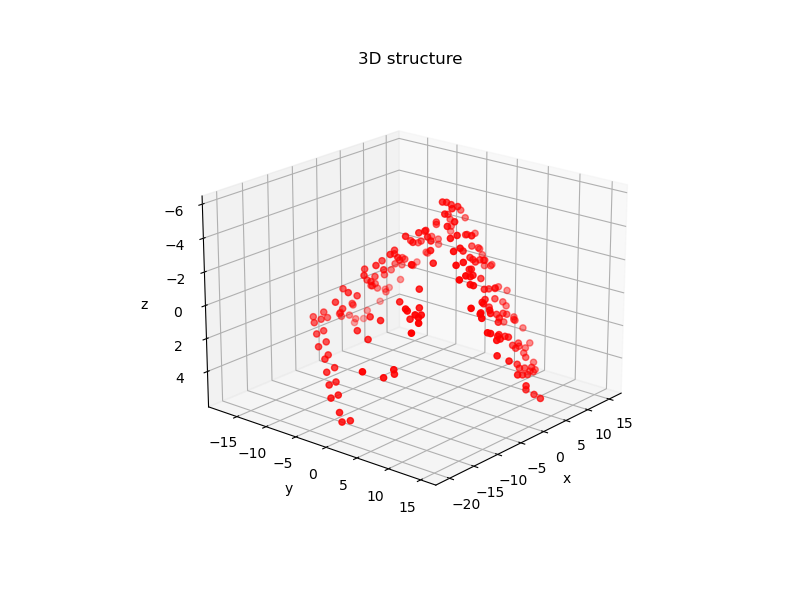

In [5]:
## Use matplotlib to display the 3D structure (in your report, you may want to include snapshots 
## from several viewpoints to show the structure clearly). Discuss whether or not the reconstruction 
## has an ambiguity.
def plot_3D(structure, view=[30,-60]):
    plt.figure(figsize=(8,6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(Structure[0,:], Structure[1,:], Structure[2,:], c='r')
    ax.view_init(view[0],view[1])
    plt.title('3D structure')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    return

plot_3D(Structure, view=[-160, -40])
plot_3D(Structure_new, view=[-160,-40])